In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
import metpy.calc as mpcalc
from metpy.units import units
from numpy import *
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset, num2date
import math
import sys
from datetime import datetime, timedelta

from geopy import distance

import cdsapi
import os
os.chdir(  "/Users/etmu9498/research/code/scripts-winter2023")
import helper_fns_winter2023 as helper_fns


In [2]:
# using a combination of ships data (for 2021 cases) and nhc tc reports (for 2022 cases),
# figure out which dates have active TC events, and get the lat / lon tc centers for these dates! where the shear centroid
# will be centered
def pull_lat_lons( tc = '2021'):
    
    # process data from SHIPS dataset to set up for 2021 intensification analysis
    # this code is based on "/code/eye-cloud-paper/figure 4 cloud dists vs TC intensification.ipynb"
    if tc == '2021':
        # define tc names used in this analysis
        tcnames_orig = ['fred', 'grace', 'henri', 'ida', 'sam']
        tcnames = []
        # only keep first 4 letters to match the format of the ships data
        for i in range(len( tcnames_orig)):
            tcnames.append( tcnames_orig[i][0:4].upper())
        year = '2021'

        # load the full ships dataset
        print( "Loading SHIPS dataset")
        os.chdir(  "/Users/etmu9498/research/data/ships/")
        file1 = open('lsdiaga_1982_2021_sat_ts_5day.txt', 'r')
        Lines = file1.readlines()
        # there are a bunch of lines in the total ships file!!
        print( "SHIPS dataset created")
        print( "Number of lines in dataset: " + str( len( Lines)))

        # lists of lists holding important date, intensity, etc information for each tc of interest!
        all_dates = []
        all_time_since_start = []
        all_datetimes = []
        all_lat = []
        all_lon = []
        all_startdate = []
        all_starttime = []

        # do this for each tc name listed above
        for strname in tcnames:
            # convenient variables for plotting
            dates = []
            time_since_start = []
            datetimes = []
            lat = []
            lon = []
            startdate = 0
            starttime = 0

            header_inds = []
            # go through all the lines
            for ind in range( len( Lines)):
                # get the heading lines, and look for this TC's cases!
                if 'HEAD' and strname  in Lines[ ind]:
                    # only keep 2021 cases
                    if Lines[ ind][ 6 : 8] == str( year[ 2:4]):
                        header_inds.append( ind)

            # print valid header indices
            # print( header_inds)
            # do this for all headers
            for headeri, headerval in enumerate( header_inds):
                # add times to the list! increments of 6 hours
                if headeri == 0:
                    time_since_start.append( 0)
                    # append starting dates and times
                    for i in range( headerval,  len( Lines) ):
                        if 'HEAD' in Lines[ i]:
                            startdate = Lines[i][6:12]
                            starttime = Lines[i][13:15]
                            break
                else:
                    # otherwise, find the most recent time and add 6 hours!
                    time_since_start.append( time_since_start[-1] + 6)

                # add dates
                for i in range( headerval,  len( Lines) ):
                    if 'HEAD' in Lines[ i]:
                        dates.append( Lines[i][6:12] )
                        break
                # add datetime objects!!
                for i in range( headerval,  len( Lines) ):
                    if 'HEAD' in Lines[ i]:
                        month = int( Lines[i][8:10] )
                        day = int( Lines[i][10:12] )
                        hours = int( Lines[i][13:15] )
                        datetime_orig = datetime( int( year), month, day, hours)
                        datetimes.append( datetime_orig.strftime( "%m/%d %Hh"))
                        break
                # search for lat and lon values!
                for i in range( headerval,  len( Lines) ):
                    if 'LON' in Lines[i]:
                        lon.append( - float( Lines[i][12 : 15]) / 10 ) # the last 3 vals for vmax at 0 hours
                        break
                for i in range( headerval,  len( Lines) ):
                    if 'LAT' in Lines[i]:
                        lat.append( float( Lines[i][11:15] ) / 10.  ) # the last 3 vals for vmax at 0 hours
                        break

            # once done looping through the headers, append the list of dates, pressures, etc to the all_ lists
            all_dates.append( dates)
            all_time_since_start.append( time_since_start)
            all_datetimes.append( datetimes)
            all_lat.append( lat)
            all_lon.append( lon)
            all_startdate.append( startdate)
            all_starttime .append( starttime)
        return np.array(tcnames_orig), all_datetimes, all_lat, all_lon
            
    # other case: process munged data from NHC reports to set up for 2022 intensification analysis
    elif tc == '2022':
        tcnames_orig_2022 = ['earl', 'fiona', 'ian', 'julia']
        # months aren't saved in the original excel files :/ so add them here! from noaa summary docs
        months = ['09', '09', '09', '10']

        # lists of lists holding important date, intensity, etc information for each tc of interest!
        all_datetimes = []
        all_lons = []
        all_lats = []

        # where 2022 munged data resides
        data_path_2022 = "/Users/etmu9498/research/data/intensity-6-hour-updates-temp/"

        # do this for each tc name listed above
        for stri, strname in enumerate( tcnames_orig_2022):
            datetimes = []

            # read in this tc's dataset
            os.chdir(data_path_2022)
            data = pd.read_excel( "tc-" + strname + ".xlsx")

            # cycle through each datetime and correct it
            for di, dval in enumerate(data['Date/Time (UTC)'].values):
                datetimes.append( months[stri] + '/' + dval[0:2] + ' ' + dval[5:7] + 'h')

            # append the list of dates, pressures, etc to the all_ lists
            all_datetimes.append( datetimes )
            all_lats.append( data['Latitude (ON)'].values.tolist())
            all_lons.append( (-1 * data['Longitude (OW)'].values).tolist())
            
        return np.array(tcnames_orig_2022), all_datetimes, all_lats, all_lons


In [3]:
# make simple scatter plots for 2021 data to confirm that data processing steps went well!
def plot_lat_lon( year='2021'):
    if year == '2021':
        names21, dt21, lat21, lon21 = pull_lat_lons( tc = '2021')
        names = names21
    elif year == '2022':
        names22, dt22, lat22, lon22 = pull_lat_lons( tc = '2022')
        names = names22
        
    for tci, tcname in enumerate(names):
        if year == '2021':
            datetimes = dt21[tci]
            lat = lat21[tci]
            lon = lon21[tci]
        elif year == '2022':
            datetimes = dt22[tci]
            lat = lat22[tci]
            lon = lon22[tci]
        tcname = names[tci].title()

        plt.figure( figsize = (6, 6))
        helper_fns.change_font_sizes( 12, 12)
        lw = 2
        plt.title( "Base Track for TC " + tcname + ", " + year)
        plt.plot( lon, lat, c='k', linewidth=lw)
        plt.ylabel( "Latitude (degrees)")
        plt.xlabel( "Longitude (degrees)")
        plt.xticks(rotation=45, ha="right")

        ax = plt.gca()
        fig = plt.gcf()
        fig.tight_layout()

        print("Plot for TC " + tcname + " Created")


In [4]:
# testing the lat lon finder scripts above!
names21, dt21, lat21, lon21 = pull_lat_lons( tc = '2021')
names22, dt22, lat22, lon22 = pull_lat_lons( tc = '2022')
# plot_lat_lon('2021')

# print(dt21)
# print(dt22)

'''
# subsetting 2021 data to just tc sam (as an example)
names21, dt21, lat21, lon21 = pull_lat_lons( tc = '2022')
print(names21)
name = 'julia'
tcind = np.where( names21 == name)[0][0]

print(tcind)
print(dt21[tcind])
'''

Loading SHIPS dataset
SHIPS dataset created
Number of lines in dataset: 1884145


"\n# subsetting 2021 data to just tc sam (as an example)\nnames21, dt21, lat21, lon21 = pull_lat_lons( tc = '2022')\nprint(names21)\nname = 'julia'\ntcind = np.where( names21 == name)[0][0]\n\nprint(tcind)\nprint(dt21[tcind])\n"

In [5]:
############# Declare time, level, and lat/lon boundaries here ##########
# do so automatically! will be useful code later :)

# inputs
year = '2021'
name = 'sam'
case = 15 # 10 # case index for this tc (which lat, lon, date to select)
lat_spacing = 10 # padding added to either side of the TC center position
lon_spacing = 10

# get location and time data for one case
names, dt, all_lats, all_lons = pull_lat_lons( tc = year)
tcind = np.where( names == name)[0][0]
datei, lati, loni = dt[tcind][case], all_lats[tcind][case], all_lons[tcind][case]

print(datei)
print(lati)
print(type(lati))
print(loni)

# convert saved dates, etc into format for era 5 analysis!
startdate = datei[0:5] + "/" + year[2:4] + " " + datei[6:8] + ":00" ## must be in this format 'MM/DD/YY HH:MM'
latN = lati + lat_spacing # lat needs no changes!
latS = lati - lat_spacing
lonW = 360 + loni - lon_spacing    # must be in degrees E (The western hemisphere is captured between 180 and 360 degrees east)
lonE = 360 + loni + lon_spacing
date = datetime.strptime(startdate,'%m/%d/%y %H:%M')
level1 = 250
level2 = 850

# need to reconvert bounds for cartopy plotting
bounds = [loni - lon_spacing, loni + lon_spacing, latS, latN]

print(bounds)

Loading SHIPS dataset
SHIPS dataset created
Number of lines in dataset: 1884145
09/26 12h
13.8
<class 'float'>
-50.0
[-60.0, -40.0, 3.8000000000000007, 23.8]


In [6]:
######### Download ERA5 data using CDS-API ##########

normal_save = "/Users/etmu9498/research/data/era5/" + year + "/" + name
test_save = "/Users/etmu9498/research/data/era5/test/"
os.chdir(test_save)
filestr = 'winds_'+date.strftime('%Y')+date.strftime('%m')+date.strftime('%d')+'_'+date.strftime('%H')+'.nc'     # you can change these filenames as you see fit


In [7]:
c = cdsapi.Client()
c.retrieve('reanalysis-era5-pressure-levels', {
    'product_type': 'reanalysis',
    'variable': ['u_component_of_wind', 'v_component_of_wind', 'geopotential'],
    'pressure_level': ['250', '850'],
    'year': date.strftime('%Y'),         # substitutes the year based off the startdate in the above cell
    'month': date.strftime('%m'),        # substitutes the month based off the startdate in the above cell
    'day': date.strftime('%d'),          # substitutes the year based off the startdate in the above cell
    'time': date.strftime('%H:%M'),      # substitutes the time based off the startdate in the above above
    'format': 'netcdf',
    }, filestr)

2023-05-22 11:23:50,500 INFO Welcome to the CDS
2023-05-22 11:23:50,501 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-05-22 11:23:50,774 INFO Request is queued
2023-05-22 11:24:12,561 INFO Request is running
2023-05-22 11:24:24,154 INFO Request is completed
2023-05-22 11:24:24,155 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data8/adaptor.mars.internal-1684776235.9210207-8648-1-965ae89e-fca2-4202-97a0-62ba3ed3a189.nc to winds_20210926_12.nc (11.9M)
2023-05-22 11:24:27,427 INFO Download rate 3.6M/s                                                                      


Result(content_length=12469364,content_type=application/x-netcdf,location=https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data8/adaptor.mars.internal-1684776235.9210207-8648-1-965ae89e-fca2-4202-97a0-62ba3ed3a189.nc)

In [8]:
######## Enter in the datasets #########
print(filestr)

# sys.path.append("/Users/etmu9498/research/data/era5")
os.chdir(test_save)
ds = xr.open_dataset(filestr).metpy.parse_cf()
ds

winds_20210926_12.nc


<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 2, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 250 850
  * time       (time) datetime64[ns] 2021-09-26T12:00:00
    metpy_crs  object Projection: latitude_longitude
Data variables:
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-22 17:23:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [17]:
######## Read in the variables ##########

lats = ds.latitude.metpy.sel(latitude=slice(latN,latS))
lons = ds.longitude.metpy.sel(longitude=slice(lonW,lonE))
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
lons_2D, lats_2D = meshgrid(lons,lats)

# upper wind
uwnd1 = ds.u.metpy.sel(time=date,level = level1,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
vwnd1 = ds.v.metpy.sel(time=date,level = level1,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
# lower wind
uwnd2 = ds.u.metpy.sel(time=date,level = level2,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
vwnd2 = ds.v.metpy.sel(time=date,level = level2,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
# upper geopot and height
geop1 = ds.z.metpy.sel(time=date,level=level1,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
hght1 = geop1/9.81
# lower geopot and height
geop2 = ds.z.metpy.sel(time=date,level=level2,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
hght2 = geop2/9.81


######### Smooth the variables ##########
smoothval = 25 # 1 -> no smoothing, 25 -> very smooth
uwnd1 = mpcalc.smooth_gaussian(uwnd1,smoothval)
vwnd1 = mpcalc.smooth_gaussian(vwnd1,smoothval)
uwnd2 = mpcalc.smooth_gaussian(uwnd2,smoothval)
vwnd2 = mpcalc.smooth_gaussian(vwnd2,smoothval)


hght1 = mpcalc.smooth_gaussian(hght1,smoothval)
hght2 = mpcalc.smooth_gaussian(hght2,smoothval)


geo1 = mpcalc.geostrophic_wind( hght1 * units.meter,dx=dx,dy=dy,latitude=lats_2D*units.degrees)   # Geostrophic wind
geo2 = mpcalc.geostrophic_wind( hght2 * units.meter,dx=dx,dy=dy,latitude=lats_2D*units.degrees)   # Geostrophic wind
age1 = mpcalc.ageostrophic_wind( hght1 * units.meter,uwnd1,vwnd1,dx=dx,dy=dy,latitude=lats)    # Ageostrophic wind
age2 = mpcalc.ageostrophic_wind( hght2 * units.meter,uwnd2,vwnd2,dx=dx,dy=dy,latitude=lats)    # Ageostrophic wind
ug1, ug2 = geo1[0], geo2[0]
vg1, vg2 = geo1[1], geo2[1]
ua1, ua2 = age1[0], age2[0]
va1, va2 = age1[1], age2[1]


In [18]:
# first, print out the wind speed shapes + values
print_shape = True
if print_shape:
    print(np.shape(lats))
    print(np.shape(lons))
    print(np.shape(uwnd1))
    print(np.shape(uwnd2))
    print(np.shape(vwnd1))
    print(np.shape(vwnd2))

print_vals = False
if print_vals:
    print(lats.values)
    print(lons.values)
    print(uwnd1[:, 0].values)
    print(241*241)


(80,)
(81,)
(80, 81)
(80, 81)
(80, 81)
(80, 81)


In [19]:
# test finding great circle distances
centerlat = lati
centerlon = loni
center = [centerlat, centerlon]

# save distances here
center_dists = np.empty( np.shape(uwnd1))
# create a distance from the TC center axis!
for i in range(np.shape(uwnd1)[0]):
    lat = lats[i]
    for j in range(np.shape(uwnd1)[0]-1):
        lon = lons[j]
        center_dists[i][j] = distance.geodesic( center, [lat, lon]).km
    if i % 20 == 0:
        print("Case " + str(i) + " complete")        

# try to trim center distances in one line of code using np.where()!
center_dists_donut = np.copy( center_dists)
trim_inds = np.where( np.logical_or( center_dists_donut <= 200., center_dists_donut >= 800. ))

'''
print(np.shape(center_dists_donut))
print(trim_inds)
print(trim_inds[0][0:300])

print(np.shape(trim_inds))
print(80*80)
'''
center_dists_donut[trim_inds[0], trim_inds[1]] = np.nan

'''
# replace distances with nans if it's smaller than 200 km, larger than 800 km
center_dists_donut = np.empty( np.shape(uwnd1))
# search down columns
for i in range(np.shape(center_dists_donut)[0]):
    # search through rows
    for j in range(np.shape(center_dists_donut)[1]):
        if center_dists[i][j] >= 200 and center_dists[i][j] <= 800:
            center_dists_donut[i][j] = center_dists[i][j]
        else:
            center_dists_donut[i][j] = np.nan

    # if i % 20 == 0:
    #     print("Case " + str(i) + " complete")

print(np.shape(center_dists_donut))
'''

Case 0 complete
Case 20 complete
Case 40 complete
Case 60 complete


'\n# replace distances with nans if it\'s smaller than 200 km, larger than 800 km\ncenter_dists_donut = np.empty( np.shape(uwnd1))\n# search down columns\nfor i in range(np.shape(center_dists_donut)[0]):\n    # search through rows\n    for j in range(np.shape(center_dists_donut)[1]):\n        if center_dists[i][j] >= 200 and center_dists[i][j] <= 800:\n            center_dists_donut[i][j] = center_dists[i][j]\n        else:\n            center_dists_donut[i][j] = np.nan\n\n    # if i % 20 == 0:\n    #     print("Case " + str(i) + " complete")\n\nprint(np.shape(center_dists_donut))\n'

In [21]:
# calculate total wind speed and wind direction at each grid point! 

# using metpy
wspd1 = mpcalc.wind_speed(uwnd1,vwnd1)   # wind speed
wspd2 = mpcalc.wind_speed(uwnd2,vwnd2)

wdir1 = mpcalc.wind_direction(uwnd1,vwnd1, convention='from')
wdir2 = mpcalc.wind_direction(uwnd2,vwnd2, convention='from')

# replace wind directions and speeds with nans if it's smaller than 200 km, larger than 800 km from tc center
wspd1_trim = np.copy(wspd1)
wspd2_trim = np.copy(wspd2)
wdir1_trim = np.copy(wdir1)
wdir2_trim = np.copy(wdir2)

# new, array code!
trim_inds = np.where( np.logical_or( center_dists <= 200., center_dists >= 800. ))
wspd1_trim[trim_inds[0], trim_inds[1]] = np.nan
wspd2_trim[trim_inds[0], trim_inds[1]] = np.nan
wdir1_trim[trim_inds[0], trim_inds[1]] = np.nan
wdir2_trim[trim_inds[0], trim_inds[1]] = np.nan


# old, manual loop code
'''
# search down columns
for i in range(np.shape(center_dists_donut)[0]):
                   
    # search through rows
    for j in range(np.shape(center_dists_donut)[1]):
        if center_dists[i][j] >= 200 and center_dists[i][j] <= 800:
            wspd1_trim[i][j] = wspd1[i][j]
            wspd2_trim[i][j] = wspd2[i][j]
            wdir1_trim[i][j] = wdir1[i][j]
            wdir2_trim[i][j] = wdir2[i][j]
        else:
            wspd1_trim[i][j] = np.nan
            wspd2_trim[i][j] = np.nan
            wdir1_trim[i][j] = np.nan
            wdir2_trim[i][j] = np.nan
'''

'''
# manual calculations... too complicated lol
wdir1 = np.empty( np.shape(uwnd1))
wdir2 = np.empty( np.shape(uwnd1))
# wspd1 = np.empty( np.shape(uwnd1))
# wspd2 = np.empty( np.shape(uwnd1))

array_uwnd1 = np.array(uwnd1)
array_uwnd2 = np.array(uwnd2)
array_vwnd1 = np.array(vwnd1)
array_vwnd2 = np.array(vwnd2)
for i in range(np.shape(center_dists_donut)[0]):
    for j in range(np.shape(center_dists_donut)[1]):
        # all of these values are between -90 and 90 because of angle stuff... need to convert to 0 t
        wdir1ij = np.degrees( np.arctan( array_vwnd1[i][j] / array_uwnd1[i][j]))
        wdir2ij = np.degrees( np.arctan( array_vwnd2[i][j] / array_uwnd2[i][j]))
    
        # 0 to 90 degrees case... need to flip angle so that 0 degrees is due north (UR / NE quadrant)
        if array_vwnd1[i][j] > 0.0 and array_uwnd1[i][j] > 0.0:
            wdir1ij = 90 - wdir1ij
        # 90 to 180 degree case (LR / SE quadrant )
        elif array_vwnd1[i][j] < 0.0 and array_uwnd1[i][j] > 0.0:
            wdir1ij = 90 + -1 * wdir1ij
        # 180 to 270 case (LL / SW quadrant)
        elif array_vwnd1[i][j] < 0.0 and array_uwnd1[i][j] < 0.0:
            wdir1ij = 180 + (90 - wdir1ij )
        # 270 to 360 case (UL / NW quadrant)
        elif array_vwnd1[i][j] > 0.0 and array_uwnd1[i][j] < 0.0:
            wdir1ij = 270 + -1 * wdir1ij
        
        # repeat for lower winds!
        # 0 to 90 degrees case... need to flip angle so that 0 degrees is due north (UR / NE quadrant)
        if array_vwnd2[i][j] > 0.0 and array_uwnd2[i][j] > 0.0:
            wdir2ij = 90 - wdir2ij
        # 90 to 180 degree case (LR / SE quadrant )
        elif array_vwnd2[i][j] < 0.0 and array_uwnd2[i][j] > 0.0:
            wdir2ij = 90 + -1 * wdir2ij
        # 180 to 270 case (LL / SW quadrant)
        elif array_vwnd2[i][j] < 0.0 and array_uwnd2[i][j] < 0.0:
            wdir2ij = 180 + (90 - wdir2ij )
        # 270 to 360 case (UL / NW quadrant)
        elif array_vwnd2[i][j] > 0.0 and array_uwnd2[i][j] < 0.0:
            wdir2ij = 270 + -1 * wdir2ij
        
        # finally, append the corrected winds to the matrices
        wdir1[i][j] = wdir1ij
        wdir2[i][j] = wdir2ij
        # wspd1[i][j] = np.sqrt( array_vwnd1[i][j]**2 + array_uwnd1[i][j]**2)
        # wspd2[i][j] = np.sqrt( array_vwnd2[i][j]**2 + array_uwnd2[i][j]**2)
'''

'\n# manual calculations... too complicated lol\nwdir1 = np.empty( np.shape(uwnd1))\nwdir2 = np.empty( np.shape(uwnd1))\n# wspd1 = np.empty( np.shape(uwnd1))\n# wspd2 = np.empty( np.shape(uwnd1))\n\narray_uwnd1 = np.array(uwnd1)\narray_uwnd2 = np.array(uwnd2)\narray_vwnd1 = np.array(vwnd1)\narray_vwnd2 = np.array(vwnd2)\nfor i in range(np.shape(center_dists_donut)[0]):\n    for j in range(np.shape(center_dists_donut)[1]):\n        # all of these values are between -90 and 90 because of angle stuff... need to convert to 0 t\n        wdir1ij = np.degrees( np.arctan( array_vwnd1[i][j] / array_uwnd1[i][j]))\n        wdir2ij = np.degrees( np.arctan( array_vwnd2[i][j] / array_uwnd2[i][j]))\n    \n        # 0 to 90 degrees case... need to flip angle so that 0 degrees is due north (UR / NE quadrant)\n        if array_vwnd1[i][j] > 0.0 and array_uwnd1[i][j] > 0.0:\n            wdir1ij = 90 - wdir1ij\n        # 90 to 180 degree case (LR / SE quadrant )\n        elif array_vwnd1[i][j] < 0.0 and a

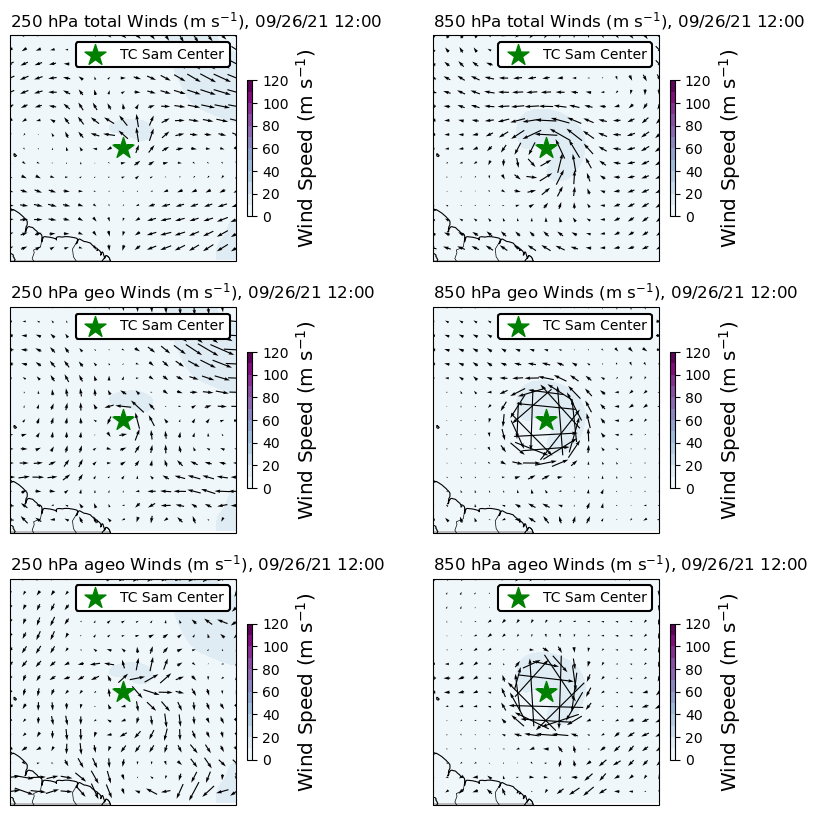

In [25]:
######## Create the plot #######

us = [uwnd1, uwnd2, ug1, ug2, ua1, ua2]
vs = [vwnd1, vwnd2, vg1, vg2, va1, va2]
spds = [wspd1, wspd2, wspd1, wspd2, wspd1, wspd2]
levels = [level1, level2, level1, level2, level1, level2]
subplotlist = [321, 322, 323, 324, 325, 326]
type = ['total', 'total', 'geo', 'geo', 'ageo', 'ageo']

#Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize= (10, 10))
#Set up the projection that will be used
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
mapcrs = ccrs.PlateCarree()
#Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# create the subplots!
for i, subplotval in enumerate(subplotlist):
    ax = plt.subplot(subplotval, projection=mapcrs) 
    ax.set_extent( bounds, ccrs.PlateCarree()) ## Can change the lat/lon bounds

    #Add geopolitical boundaries for map reference
    ax.add_feature(cfeature.LAND, facecolor="#bdbdbd") 
    countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
    ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
    ax.coastlines('50m', linewidth=0.8)

    #Set up contour and fill intervals
    wspd_levels = arange(0,130,10)
    #Plot the variables
    wspd_fcontours = plt.contourf(lons, lats, spds[i], levels=wspd_levels, cmap=get_cmap('BuPu'), alpha=1, transform=ccrs.PlateCarree())
    # Plot total wind barbs
    udivbrb = us[i] 
    vdivbrb = vs[i]
    wind_slice = (slice(None, None, 5), slice(None, None, 5))
    ax.quiver(lons[wind_slice[0]], lats[wind_slice[1]],
              udivbrb[wind_slice], # .m
              vdivbrb[wind_slice], # .m
              pivot='mid', color='black',
              #scale=0.5e-6, scale_units='inches',
              width=0.005,
              transform=datacrs)

    #Colorbar and contour labels
    cb = fig.colorbar(wspd_fcontours, orientation='vertical', pad=0.03, extendrect=True, aspect=25, shrink=0.6)
    cb.set_label('Wind Speed (m s$^{-1}$)', size='x-large') 
    plt.grid('on')

    plt.scatter( loni, lati, c='g', s=250, marker='*', label='TC Sam Center', zorder=5)
    leg = plt.legend(loc='upper right', framealpha=1.0, fontsize=10)
    leg.get_frame().set_linewidth( 1.5) 
    leg.get_frame().set_edgecolor('k')


    #Plot two titles, one on right and left side
    plt.title(str( levels[i]) + ' hPa ' + type[i] + ' Winds (m s$^{-1}$), ' + startdate, loc='left') 

plt.show()

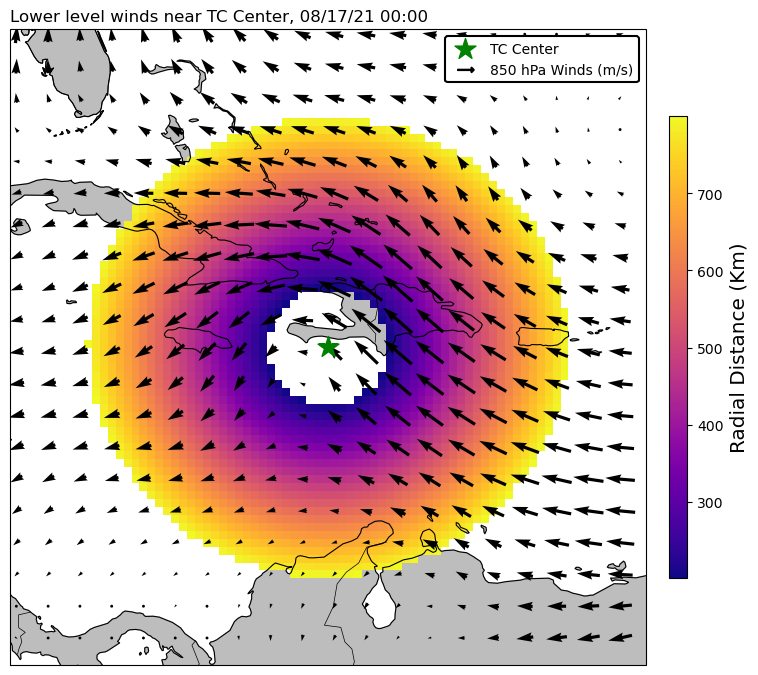

In [57]:
# repeat the plot above, but for radial distance, not wind speed!

#Set up the projection that will be used
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
mapcrs = ccrs.PlateCarree()

#Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

#Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize= (10, 10))
ax = plt.subplot(111, projection=mapcrs) 

ax.set_extent( bounds, ccrs.PlateCarree()) ## Can change the lat/lon bounds

#Add geopolitical boundaries for map reference
ax.add_feature(cfeature.LAND, facecolor="#bdbdbd") 
countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
ax.coastlines('50m', linewidth=0.8)

#Set up contour and fill intervals
dist_levels = arange(0,900,100)

#Plot the variables
# wspd_fcontours = plt.contourf(lons, lats, center_dists_donut, levels=dist_levels, cmap=get_cmap('plasma'), alpha=1, transform=ccrs.PlateCarree())
wspd_fcontours = plt.pcolormesh(lons, lats, center_dists_donut, cmap=get_cmap('plasma'), alpha=1, transform=ccrs.PlateCarree())

#Colorbar and contour labels
cb = fig.colorbar(wspd_fcontours, orientation='vertical', pad=0.03, extendrect=True, aspect=25, shrink=0.6)
cb.set_label('Radial Distance (Km)', size='x-large') 
plt.grid('on')

plt.scatter( loni, lati, c='g', s=250, marker='*', label='TC Center', zorder=5)

wind_type = 'Lower'

# Plot total wind barbs
if wind_type == 'Upper':
    udivbrb = us[0] 
    vdivbrb = vs[0]
    spd_label = '250 hPa Winds (m/s)'
else:
    udivbrb = us[1] 
    vdivbrb = vs[1]
    spd_label = '850 hPa Winds (m/s)'
    
wind_slice = (slice(None, None, 4), slice(None, None, 4))
ax.quiver(lons[wind_slice[0]], lats[wind_slice[1]],
          udivbrb[wind_slice], # .m
          vdivbrb[wind_slice], # .m
          pivot='mid', color='black',
          #scale=0.5e-6, scale_units='inches',
          width=0.005,
          transform=datacrs)

# add a fake arrow for the legend!
testarrow = plt.scatter( -1000, -1000, c='k', marker=r'$\longrightarrow$', s=150, label=spd_label )

leg = plt.legend(loc='upper right', framealpha=1.0, fontsize=10)
leg.get_frame().set_linewidth( 1.5) 
leg.get_frame().set_edgecolor('k')


#Plot two titles, one on right and left side
plt.title( wind_type + " level winds near TC Center, " + startdate, loc='left') 

plt.show()

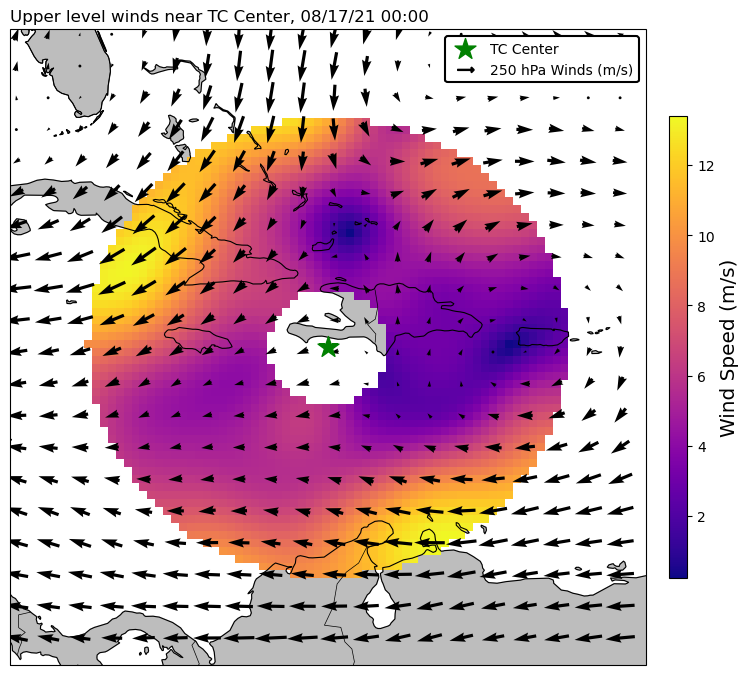

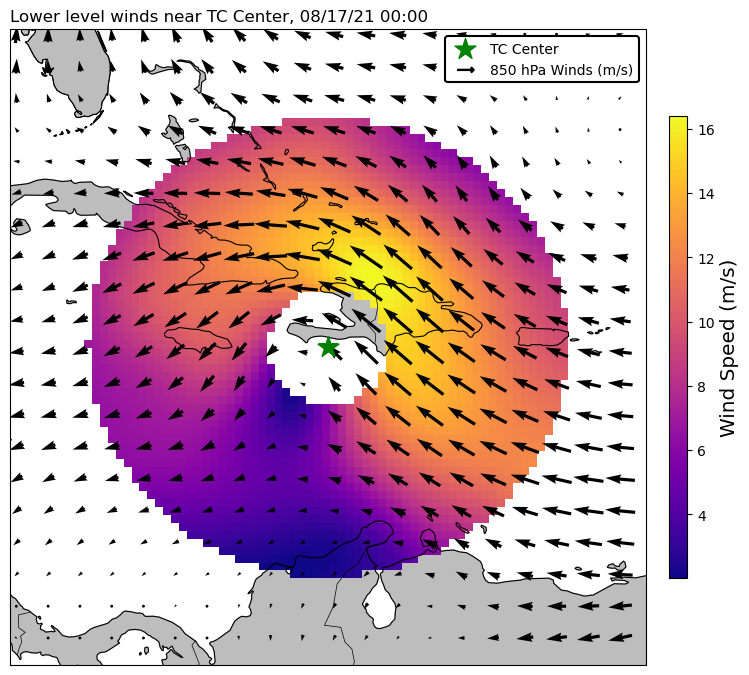

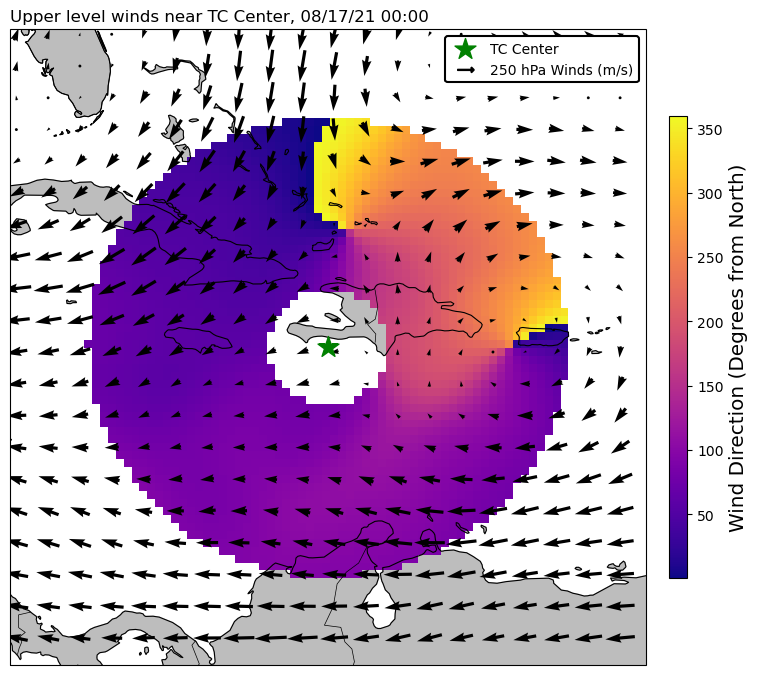

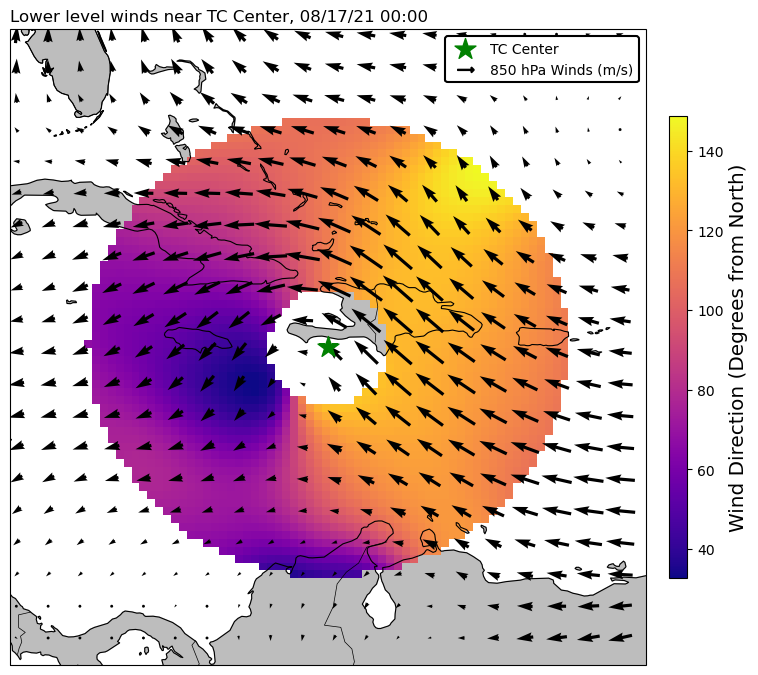

In [58]:
# Plot total wind speed and wind directions at one level as a colormap (show grids)

#Set up the projection that will be used
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
mapcrs = ccrs.PlateCarree()

#Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

for i in range(4):
    #Start the figure and create plot axes with proper projection
    fig = plt.figure(1, figsize= (10, 10))
    ax = plt.subplot(111, projection=mapcrs) 

    ax.set_extent( bounds, ccrs.PlateCarree()) ## Can change the lat/lon bounds

    #Add geopolitical boundaries for map reference
    ax.add_feature(cfeature.LAND, facecolor="#bdbdbd") 
    countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
    ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
    ax.coastlines('50m', linewidth=0.8)


    ############# choose vars here for plot! ###############
    add_arrows = True
    # not the cleanest code, try to fix when writing real script later!
    if i == 0:
        wind_type = 'Upper'
        var = 'spd'
    elif i == 1:
        wind_type = 'Lower'
        var = 'spd'
    elif i == 2:
        wind_type = 'Upper'
        var = 'dir'
    elif i == 3:
        wind_type = 'Lower'
        var = 'dir'

    # Plot total wind barbs
    if wind_type == 'Upper':
        udivbrb = us[0] 
        vdivbrb = vs[0]
        spd_label = '250 hPa Winds (m/s)'
        if var == 'spd':
            wspd_fcontours = plt.pcolormesh(lons, lats, wspd1_trim, cmap=get_cmap('plasma'), alpha=1, transform=ccrs.PlateCarree())
            cb = fig.colorbar(wspd_fcontours, orientation='vertical', pad=0.03, extendrect=True, aspect=25, shrink=0.6)
            cb.set_label('Wind Speed (m/s)', size='x-large') 
        elif var == 'dir':
            # levels = arange(0,370,90)
            wspd_fcontours = plt.pcolormesh(lons, lats, wdir1_trim, cmap=get_cmap('plasma'), alpha=1, transform=ccrs.PlateCarree()) 
            cb = fig.colorbar(wspd_fcontours, orientation='vertical', pad=0.03, extendrect=True, aspect=25, shrink=0.6)
            cb.set_label('Wind Direction (Degrees from North)', size='x-large') 
    else:
        udivbrb = us[1] 
        vdivbrb = vs[1]
        spd_label = '850 hPa Winds (m/s)'
        if var == 'spd':
            wspd_fcontours = plt.pcolormesh(lons, lats, wspd2_trim, cmap=get_cmap('plasma'), alpha=1, transform=ccrs.PlateCarree())
            cb = fig.colorbar(wspd_fcontours, orientation='vertical', pad=0.03, extendrect=True, aspect=25, shrink=0.6)
            cb.set_label('Wind Speed (m/s)', size='x-large') 
        elif var == 'dir':
            # levels = arange(0,370,90)
            wspd_fcontours = plt.pcolormesh(lons, lats, wdir2_trim, cmap=get_cmap('plasma'), alpha=1, transform=ccrs.PlateCarree())
            cb = fig.colorbar(wspd_fcontours, orientation='vertical', pad=0.03, extendrect=True, aspect=25, shrink=0.6)
            cb.set_label('Wind Direction (Degrees from North)', size='x-large')

    # tc center location
    plt.scatter( loni, lati, c='g', s=250, marker='*', label='TC Center', zorder=5)

    if add_arrows:
        wind_slice = (slice(None, None, 4), slice(None, None, 4))
        ax.quiver(lons[wind_slice[0]], lats[wind_slice[1]],
                  udivbrb[wind_slice], # .m
                  vdivbrb[wind_slice], # .m
                  pivot='mid', color='black',
                  #scale=0.5e-6, scale_units='inches',
                  width=0.005,
                  transform=datacrs)

    # add a fake arrow for the legend!
    testarrow = plt.scatter( -1000, -1000, c='k', marker=r'$\longrightarrow$', s=150, label=spd_label )

    leg = plt.legend(loc='upper right', framealpha=1.0, fontsize=10)
    leg.get_frame().set_linewidth( 1.5) 
    leg.get_frame().set_edgecolor('k')


    #Plot two titles, one on right and left side
    plt.title( wind_type + " level winds near TC Center, " + startdate, loc='left') 

    plt.show()

In [59]:
# print wind speed and direction averages!
print("upper level wind mean = " + str( np.round( np.nanmean( wspd1_trim), 3)) + " m/s")
print("upper level wind dir mean = " + str( np.round( np.nanmean( wdir1_trim), 3)) + " deg")

print("lower level wind mean = " + str( np.round( np.nanmean( wspd2_trim), 3)) + " m/s")
print("lower level wind dir mean = " + str( np.round( np.nanmean( wdir2_trim))) + " m/s")

# print out wind shear stats!
print("shear strength = " + str( np.nanmean( wspd1_trim) - np.nanmean( wspd2_trim) ))
print("shear direction = " + str( np.nanmean( wdir1_trim) - np.nanmean( wdir2_trim) ))

upper level wind mean = 6.694 m/s
upper level wind dir mean = 119.51 deg
lower level wind mean = 9.427 m/s
lower level wind dir mean = 98.0 m/s
shear strength = -2.7330947
shear direction = 21.982254
